<a href="https://colab.research.google.com/github/Mario-RJunior/olist-e-commerce/blob/master/time_series_analysis_testes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Análise Temporal

Nesta etapa do trabalho estaremos focados em estudar sobre a sazonalidade e as tendências das compras online e para isso faremos uma análise utilizando as séries temporais correspondentes. Como produto final iremos criar um modelo preditivo, ou seja, fazer um **forecast** para estipular as vendas em instantes futuros.

Assim, nosso primeiro passo é importar as bibliotecas a serem utilizadas e carregar os dados que precisaremos para tal análise.

### 1) Importando e carregando os dados

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from fbprophet import Prophet
from datetime import datetime, date

In [2]:
! git clone https://github.com/Mario-RJunior/olist-e-commerce

Cloning into 'olist-e-commerce'...
remote: Enumerating objects: 132, done.
remote: Counting objects: 100% (132/132), done.
remote: Compressing objects: 100% (132/132), done.
remote: Total 512 (delta 77), reused 0 (delta 0), pack-reused 380
Receiving objects: 100% (512/512), 33.76 MiB | 15.79 MiB/s, done.
Resolving deltas: 100% (305/305), done.


Inicialmente iremos selecionar as colunas que iremos utilizar e a seguir agrupá-las para gerar o dataframe.

In [3]:
# Selecionando as colunas para uso
orders_col = ['order_id', 'order_status', 'order_purchase_timestamp', 
              'order_approved_at', 'order_delivered_carrier_date', 
              'order_delivered_customer_date', 'order_estimated_delivery_date']
orders_items_col = ['order_id', 'shipping_limit_date', 'price']

In [4]:
# Carregando os datasets
orders = pd.read_csv('olist-e-commerce/datasets/olist_orders_dataset.csv', 
                     usecols=orders_col)
orders_items = pd.read_csv('olist-e-commerce/datasets/olist_order_items_dataset.csv', 
                           usecols=orders_items_col)

In [5]:
# Junção dos dataframes
df = pd.merge(right=orders_items,
             left=orders,
             on='order_id')

In [6]:
df.head()

,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,shipping_limit_date,price
0,e481f51cbdc54678b7cc49136f2d6af7,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,2017-10-06 11:07:15,29.99
1,53cdb2fc8bc7dce0b6741e2150273451,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,2018-07-30 03:24:27,118.70
2,47770eb9100c2d0c44946d9cf07ec65d,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,2018-08-13 08:55:23,159.90
3,949d5b44dbf5de918fe9c16f97b45f8a,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,2017-11-23 19:45:59,45.00
4,ad21c59c0840e6cb83a9ceb5573f8159,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,2018-02-19 20:31:37,19.90


### 2) Verificando a consistência dos dados

In [7]:
df.shape

(112650, 9)

- Verificando os tipos das variáveis.

In [8]:
# Tipo das variáveis
df.dtypes

order_id                          object
order_status                      object
order_purchase_timestamp          object
order_approved_at                 object
order_delivered_carrier_date      object
order_delivered_customer_date     object
order_estimated_delivery_date     object
shipping_limit_date               object
price                            float64
dtype: object

Agora, como desejamos trabalhar com séries temporais devemos então converter as respectivas colunas para o formato *datetime*, uma vez que elas estão originalmente no formato *object*.

In [9]:
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])
df['order_approved_at'] = pd.to_datetime(df['order_approved_at'])
df['order_delivered_carrier_date'] = pd.to_datetime(df['order_delivered_carrier_date'])
df['order_delivered_customer_date'] = pd.to_datetime(df['order_delivered_customer_date'])
df['order_estimated_delivery_date'] = pd.to_datetime(df['order_estimated_delivery_date'])
df['shipping_limit_date'] = pd.to_datetime(df['shipping_limit_date'])

Uma vez convertidas para datetime iremos fazer mais um tratamento, sobretudo na coluna "order_purchase_timestamp". Como queremos analisar o comportamento das compras diárias tais como tendência e sazonalidade, iremos remover a hora de cada registro e considerar apenas as datas em que as compras ocorreram.


In [10]:
# Pegando apenas a data da coluna "order_purchase_timestamp"
df['order_purchase_timestamp'] = df['order_purchase_timestamp'].apply(lambda x: x.date())

# Convertendo novamente a data diária para formato datetime
df['order_purchase_timestamp'] = df['order_purchase_timestamp'].apply(lambda x: datetime(x.year, x.month, x.day))

In [11]:
# Confirmando os tipos de dados
df.dtypes

order_id                                 object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
shipping_limit_date              datetime64[ns]
price                                   float64
dtype: object

In [12]:
# Verificando a existência de valores nulos
df.isnull().sum()

order_id                            0
order_status                        0
order_purchase_timestamp            0
order_approved_at                  15
order_delivered_carrier_date     1194
order_delivered_customer_date    2454
order_estimated_delivery_date       0
shipping_limit_date                 0
price                               0
dtype: int64

### 3) Explorando e tratando a base de dados

In [13]:
# Verificando as datas da primeira e da última compra
print('Data mínima: {} \nData máxima: {}'.format(df['order_purchase_timestamp'].min(), 
                                                 df['order_purchase_timestamp'].max()))

Data mínima: 2016-09-04 00:00:00 
Data máxima: 2018-09-03 00:00:00


In [14]:
df.groupby([df['order_purchase_timestamp'].dt.year,
           df['order_purchase_timestamp'].dt.month]).count()['order_id']

order_purchase_timestamp  order_purchase_timestamp
2016                      9                              6
                          10                           363
                          12                             1
2017                      1                            955
                          2                           1951
                          3                           3000
                          4                           2684
                          5                           4136
                          6                           3583
                          7                           4519
                          8                           4910
                          9                           4831
                          10                          5322
                          11                          8665
                          12                          6308
2018                      1                           8208
     

Note que no ano de 2016 temos alguns valores que não apresentam-se coerentes com o restante dos meses. Portanto iremos desconsiderar tais valores e criar o modelo utilizando todo o ano de 2017 e os nove meses de 2018.

Note ainda que do resultado acima é possível perceber que os dados referentes a 2016 somam 370 registros. Logo, iremos ordernar estas datas, criar uma lista com os índices de todos os 370 registros e deletar tais linhas.

In [15]:
# Criando uma lista com os índices
ano_2016_index = df['order_purchase_timestamp'].sort_values().index[:370]
ano_2016_index

Int64Index([  5085,   5086,   4925,  34804,  34802,  34803,  93991, 110955,
            100101,  70259,
            ...
             77891,  28766,  92287, 103736,  59722,  59721,  59723,  35343,
             90652,  45006],
           dtype='int64', length=370)

In [16]:
# Excluindo estas linhas
df.drop(index=ano_2016_index, inplace=True)

In [17]:
# Fazendo uma nova verificação
df.groupby([df['order_purchase_timestamp'].dt.year,
           df['order_purchase_timestamp'].dt.month]).count()['order_id']

order_purchase_timestamp  order_purchase_timestamp
2017                      1                            955
                          2                           1951
                          3                           3000
                          4                           2684
                          5                           4136
                          6                           3583
                          7                           4519
                          8                           4910
                          9                           4831
                          10                          5322
                          11                          8665
                          12                          6308
2018                      1                           8208
                          2                           7672
                          3                           8217
                          4                           7975
     

### 4) Plotando comportamento das séries temporais

Agora, iremos definir duas bases de dados:

1) Considerando a quantidade de produtos que foram vendidos por mês.

2) Considerando o valor obtido por mês.

A seguir, iremos fazer um gráfico para cada situação para entender o comportamento das séries em ambos os casos.

- Plotando os dados para a quantidade de produtos vendidos mensalmente

In [18]:
df_group_quant = df.groupby(df['order_purchase_timestamp']).count()['order_id']
df_group_quant

order_purchase_timestamp
2017-01-05    32
2017-01-06     4
2017-01-07     5
2017-01-08     6
2017-01-09     6
              ..
2018-08-26    82
2018-08-27    71
2018-08-28    45
2018-08-29    16
2018-09-03     1
Name: order_id, Length: 603, dtype: int64

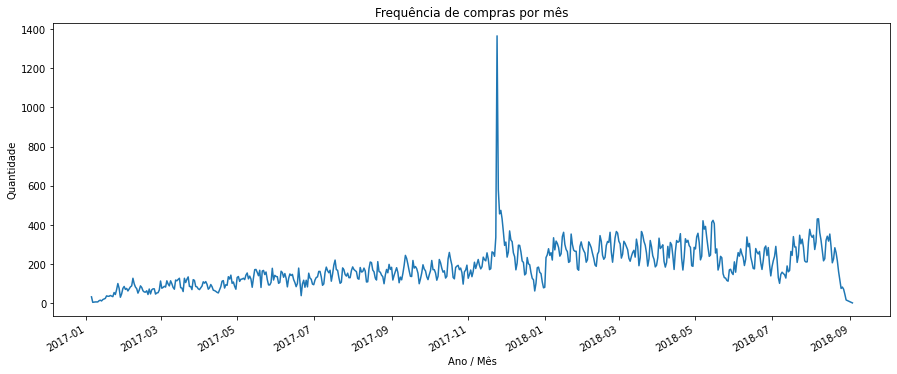

In [19]:
df_group_quant.plot(figsize=(15,6))
plt.title('Frequência de compras por mês')
plt.xlabel('Ano / Mês')
plt.ylabel('Quantidade')
plt.show()

- Plotando os dados para o total de dinheiro arrecadado pelas vendas mensalmente

In [20]:
df_group_price = df.groupby(df['order_purchase_timestamp']).sum()['price']
df_group_price

order_purchase_timestamp
2017-01-05     396.90
2017-01-06     916.38
2017-01-07    1351.90
2017-01-08     709.58
2017-01-09     673.79
               ...   
2018-08-26    8070.71
2018-08-27    5345.91
2018-08-28    3673.91
2018-08-29    1546.04
2018-09-03     145.00
Name: price, Length: 603, dtype: float64

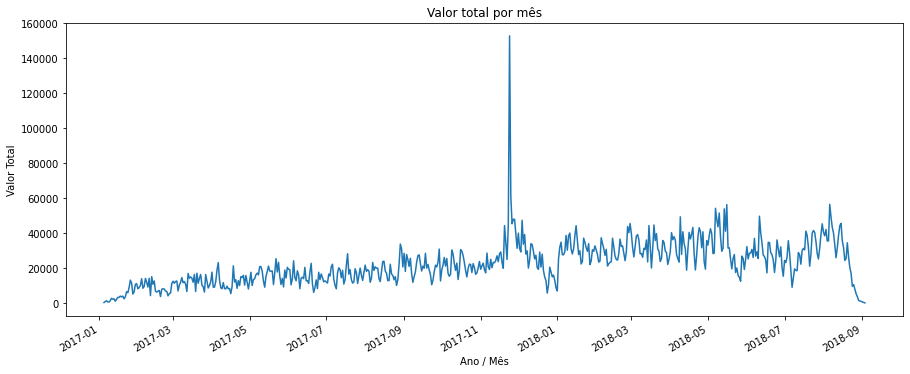

In [21]:
df_group_price.plot(figsize=(15,6))
plt.title('Valor total por mês')
plt.xlabel('Ano / Mês')
plt.ylabel('Valor Total')
plt.show()

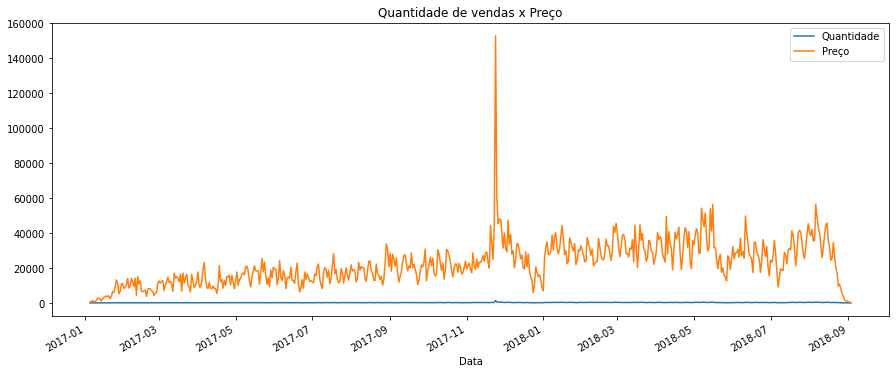

In [22]:
# Plotando ambos os gráficos juntos
df_group_quant.plot(figsize=(15,6), label='Quantidade')
df_group_price.plot(figsize=(15,6), label='Preço')
plt.title('Quantidade de vendas x Preço')
plt.xlabel('Data')
plt.legend(loc='best')
plt.show()

Note que apesar de ambos os gráficos serem muito semelhantes eles apresentam-se em escalas bem diferentes o que faz com que o gráfico da quantidade fique praticamente uma linha reta em relação ao dos preços.

### 5) Fazendo o forecast e analisando tendência e sazonalidade

- Criação do modelo usando o Prophet

Nesta etapa iremos utilizar a biblioteca fbprophet para gerar um modelo com o intuito de encontrar sazonalidade, tendência e fazer algumas previsões para compras nos meses futuros.

A seguir, precisaremos criar um dataframe apropriado para utilização do Prophet em ambos os casos.

In [23]:
# Criação do modelo
model_quant = Prophet(yearly_seasonality=True)
model_preco = Prophet(yearly_seasonality=True)

In [24]:
# Adicionando sazonalidade mensal
model_quant.add_seasonality(name='monthly', period=30.5, fourier_order=5)
model_preco.add_seasonality(name='monthly', period=30.5, fourier_order=5)

- Criando os respectivos dataframes

1) Considerando a quantidade de vendas

In [25]:
# Criação do dataframe das quantidades
ts_quant = df.groupby('order_purchase_timestamp').count()['order_id'].reset_index()
ts_quant.rename(columns= {
    'order_purchase_timestamp': 'ds',
    'order_id': 'y'
    }, inplace=True)
ts_quant.head()

,ds,y
0,2017-01-05,32
1,2017-01-06,4
2,2017-01-07,5
3,2017-01-08,6
4,2017-01-09,6


2) Considerando o preço total das vendas

In [26]:
# Criando o dataframe do valor total das vendas
ts_preco = df.groupby('order_purchase_timestamp').sum()['price'].reset_index()
ts_preco.rename(columns= {
    'order_purchase_timestamp': 'ds',
    'price': 'y'
    }, inplace=True)
ts_preco.head()

,ds,y
0,2017-01-05,396.90
1,2017-01-06,916.38
2,2017-01-07,1351.90
3,2017-01-08,709.58
4,2017-01-09,673.79


- Treinando o modelo e fazendo a previsão

Agora, iremos fazer o treinamento para os dois casos acima e a seguir fazer as respectivas previsões.

1) Considerando a quantidade de vendas

In [27]:
# Fazendo o treinamento
model_quant.fit(ts_quant)

# Criando um dataframe para dados futuros
future_quant = model_quant.make_future_dataframe(periods = 30, freq = 'D')

# Fazendo a previsão
forecast_quant = model_quant.predict(future_quant)
forecast_quant[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(30)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat,yhat_lower,yhat_upper
603,2018-09-04,208.819267,140.684160,279.119117
604,2018-09-05,210.465350,137.670501,280.033015
605,2018-09-06,210.756019,133.564451,281.426340
606,2018-09-07,204.301535,131.483923,280.012257
607,2018-09-08,155.696554,84.627592,228.446077
608,2018-09-09,165.250100,91.279363,238.469623
609,2018-09-10,219.733504,143.101280,297.119722
610,2018-09-11,224.976120,150.775205,295.915226
611,2018-09-12,225.212587,149.392230,294.667252
612,2018-09-13,223.019149,151.558832,298.988302


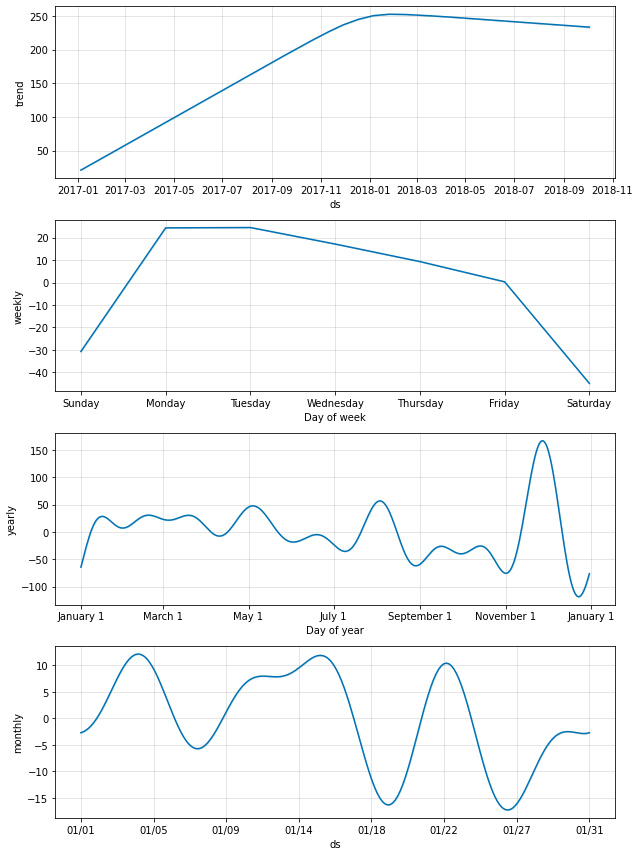

In [28]:
# Plotando os gráficos de tendência
model_quant.plot_components(forecast_quant);

2) Considerando o preço total das vendas

In [29]:
# Fazendo o treinamento
model_preco.fit(ts_preco)

# Criando um dataframe para dados futuros
future_preco = model_preco.make_future_dataframe(periods = 30, freq = 'D')

# Fazendo a previsão
forecast_preco = model_preco.predict(future_preco)
forecast_preco[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(30)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat,yhat_lower,yhat_upper
603,2018-09-04,28652.081344,19868.382039,38927.677416
604,2018-09-05,29216.894198,19687.895223,38507.742546
605,2018-09-06,29151.575614,19741.245559,38302.174486
606,2018-09-07,28501.692504,19615.472529,38358.529036
607,2018-09-08,22635.967584,13271.431452,32437.010954
608,2018-09-09,23348.718829,13533.407491,31935.391194
609,2018-09-10,30761.557839,21243.468336,40092.818778
610,2018-09-11,31036.258059,21481.955499,40826.787371
611,2018-09-12,30857.491034,21647.232251,39476.722353
612,2018-09-13,29937.587212,20342.552073,38824.112622


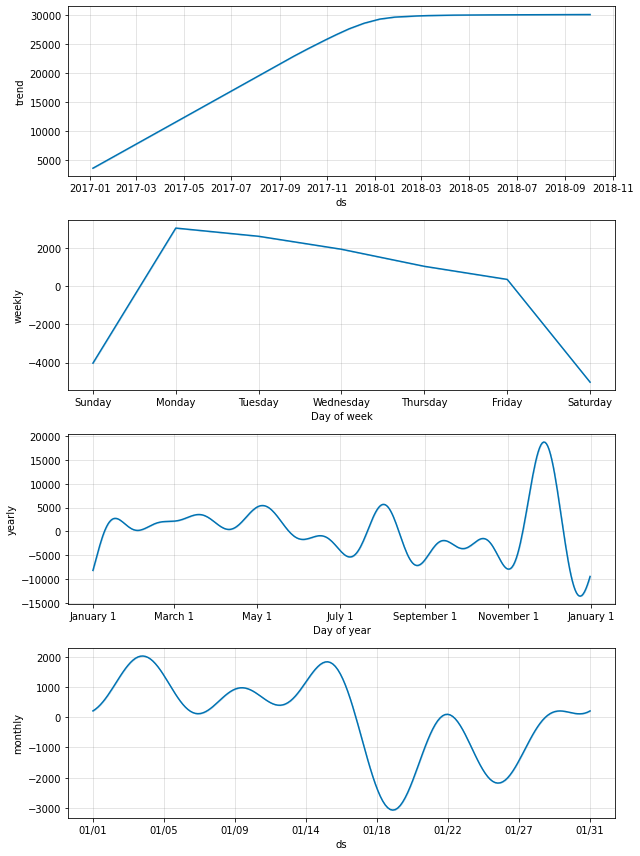

In [30]:
# Plotando os gráficos de tendência
model_preco.plot_components(forecast_preco);

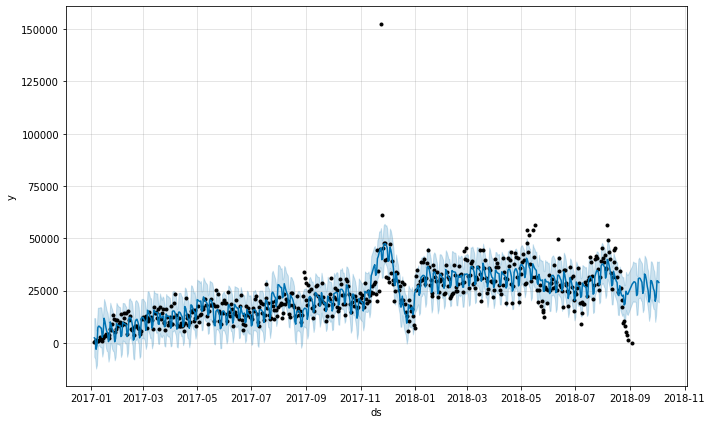

In [31]:
# Plotando o gráfico das previsões
model_preco.plot(forecast_preco);

### 6) Testando o modelo retirando outlier

Podemos ver pelo plot do forecast acima que há um ponto representando um valor de compra de mais de 150 mil reais, se destacando muito mais do que os outros. Neste caso, iremos fazer um teste que consiste em considerar este ponto como um outlier, removê-lo da amostra e repetir o processo.

In [33]:
# Identificando o outlier
ts_preco.query('y > 150000')

,ds,y
323,2017-11-24,152653.74


Vemos que o índice do outlier é 323. Então, usaremos o comando *drop()* para eliminarmos este registro.

In [34]:
# Eliminando o outlier
ts_preco_sem_outlier = ts_preco.drop(index=323)

In [36]:
ts_preco.shape

(603, 2)

In [35]:
ts_preco_sem_outlier.shape

(602, 2)

Conferimos então que temos um registro a menos em relação ao dataframe ***ts_preco*** original.